<a href="https://colab.research.google.com/github/shahin-ro/Flower-Recognition/blob/main/Flower_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports TensorFlow, Keras, Matplotlib, NumPy, OS, and KaggleHub.Sets up libraries for dataset handling, model building, and visualization.**

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import matplotlib.pyplot as plt
import numpy as np
import os
import kagglehub

# **Defines the Kaggle dataset name as "alxmamaev/flowers-recognition".Used for downloading the flower recognition dataset.**

In [2]:
KAGGLE_DATASET_NAME = "alxmamaev/flowers-recognition"

# **Sets image size to 128x128, batch size to 32, and epochs to 10. Defines constants for data processing and training.**

In [3]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10

# **Specifies 80% training, 10% validation, and 10% test splits. Ensures split percentages sum to 1.0.**

In [4]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# **Combines validation and test split sizes and checks for valid split sum. Exits if splits don’t total 1.0.**

In [5]:
VAL_TEST_SPLIT_SIZE = VAL_SPLIT + TEST_SPLIT
if TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT != 1.0:
    print("Error: Data split percentages must sum to 1.0")
    exit()

# **Downloads the Kaggle dataset using KaggleHub and sets the data directory. Handles potential subfolder issues with error checking.**

In [6]:
print(f"Downloading dataset: {KAGGLE_DATASET_NAME} using kagglehub...")
try:
    data_root_dir = kagglehub.dataset_download(KAGGLE_DATASET_NAME)
    print(f"Dataset downloaded and extracted to: {data_root_dir}")

    potential_data_dir = os.path.join(data_root_dir, 'flowers')

    if os.path.exists(potential_data_dir):
         data_dir = potential_data_dir
         print(f"Using data directory: {data_dir}")
    else:

         data_dir = data_root_dir
         print(f"Warning: Could not find '{os.path.join(KAGGLE_DATASET_NAME.split('/')[-1], 'flowers')}' subfolder. Using root download directory: {data_dir}")
         print("Please check the extracted dataset structure if you encounter issues.")

except Exception as e:
    print(f"Error downloading dataset using kagglehub: {e}")
    print("Please ensure you have the Kaggle API installed and configured correctly.")
    print("See instructions here: https://www.kaggle.com/docs/api")
    exit()

Dataset downloaded and extracted to: /kaggle/input/flowers-recognition
Using data directory: /kaggle/input/flowers-recognition/flowers


# **Loads training dataset (80% split) from the directory using TensorFlow. Configures image size, batch size, and shuffling with a seed.**

In [7]:
print(f"Loading training data from: {data_dir} with {TRAIN_SPLIT*100}% split...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VAL_TEST_SPLIT_SIZE,
    subset='training'
)

Loading training data from: /kaggle/input/flowers-recognition/flowers with 80.0% split...
Found 4317 files belonging to 5 classes.
Using 3454 files for training.


# **Loads validation/test dataset (20% split) from the directory. Uses same configuration as training for consistency.**

In [8]:
print(f"Loading validation/test data from: {data_dir} with {VAL_TEST_SPLIT_SIZE*100}% split...")
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VAL_TEST_SPLIT_SIZE,
    subset='validation'
)

Loading validation/test data from: /kaggle/input/flowers-recognition/flowers with 20.0% split...
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


# **Extracts class names and splits validation/test dataset into validation and test sets. Prints batch counts for training, validation, and test datasets.**

In [9]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")


val_test_cardinality = tf.data.experimental.cardinality(val_test_ds).numpy()

if val_test_cardinality == tf.data.experimental.INFINITE_CARDINALITY or val_test_cardinality == tf.data.experimental.UNKNOWN_CARDINALITY:
     print("Warning: Cannot determine dataset cardinality precisely. Splitting val/test by batches might be inexact.")
     num_val_batches = int(val_test_cardinality * (VAL_SPLIT / VAL_TEST_SPLIT_SIZE)) if VAL_TEST_SPLIT_SIZE > 0 else 0
else:
     num_val_batches = val_test_cardinality * VAL_SPLIT // VAL_TEST_SPLIT_SIZE if VAL_TEST_SPLIT_SIZE > 0 else 0
     num_val_batches = min(num_val_batches, val_test_cardinality)


print(f"Splitting validation/test dataset ({val_test_cardinality} batches total) into validation ({num_val_batches} batches) and test ({val_test_cardinality - num_val_batches} batches).")

valid_ds = val_test_ds.take(num_val_batches)
test_ds = val_test_ds.skip(num_val_batches)

print(f"Loaded {tf.data.experimental.cardinality(train_ds).numpy()} training batches")
print(f"Loaded {tf.data.experimental.cardinality(valid_ds).numpy()} validation batches")
print(f"Loaded {tf.data.experimental.cardinality(test_ds).numpy()} test batches")

Found 5 classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Splitting validation/test dataset (27 batches total) into validation (13.0 batches) and test (14.0 batches).
Loaded 108 training batches
Loaded 13 validation batches
Loaded 14 test batches


# **Normalizes images to [0,1] and applies caching/prefetching for efficiency. Prepares training, validation, and test datasets for model input.**

In [10]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
valid_ds = valid_ds.map(preprocess)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Builds a CNN with Conv2D, MaxPooling, Flatten, and Dense layers. Output layer uses softmax for multi-class classification.**

In [11]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(), # Use Flatten as in the original example
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax') # Output layer with number of classes
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Compiles the model with Adam optimizer and trains for 10 epochs. Uses validation data and prints model summary.**

In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- 5. Train the Model ---
print("\nTraining the model...")
history = model.fit(
    train_ds,
    validation_data=valid_ds, # Use validation data
    epochs=EPOCHS
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,973 (12.47 MB)

 Trainable params: 3,267,973 (12.47 MB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 162ms/step - accuracy: 0.3490 - loss: 1.4425 - val_accuracy: 0.5625 - val_loss: 1.0209
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5940 - loss: 1.0238 - val_accuracy: 0.6202 - val_loss: 0.9437
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6820 - loss: 0.8313 - val_accuracy: 0.6755 - val_loss: 0.8515
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7672 - loss: 0.6160 - val_accuracy: 0.6659 - val_loss: 0.9268
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8201 - loss: 0.4890 - val_accuracy: 0.6707 - val_loss: 1.0194
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8686 - loss: 0.3738 - val_accuracy: 0.5817 - val_loss: 1.4956
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8847 - loss: 0.3230 - val_accuracy: 0.5817 - val_loss: 1.5175
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9192 

# **Evaluates the model on the test dataset. Prints test loss and accuracy.**

In [13]:
print("\nEvaluating the model...")
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f'\nTest accuracy: {test_acc}')


Evaluating the model...
14/14 - 3s - 210ms/step - accuracy: 0.6174 - loss: 1.8442

Test accuracy: 0.6174496412277222


#**Fetches a batch of test images and visualizes predictions. Displays up to 10 images with true/predicted labels using Matplotlib.**


Fetching a batch of test data for plotting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Displaying predictions for a batch of test images:


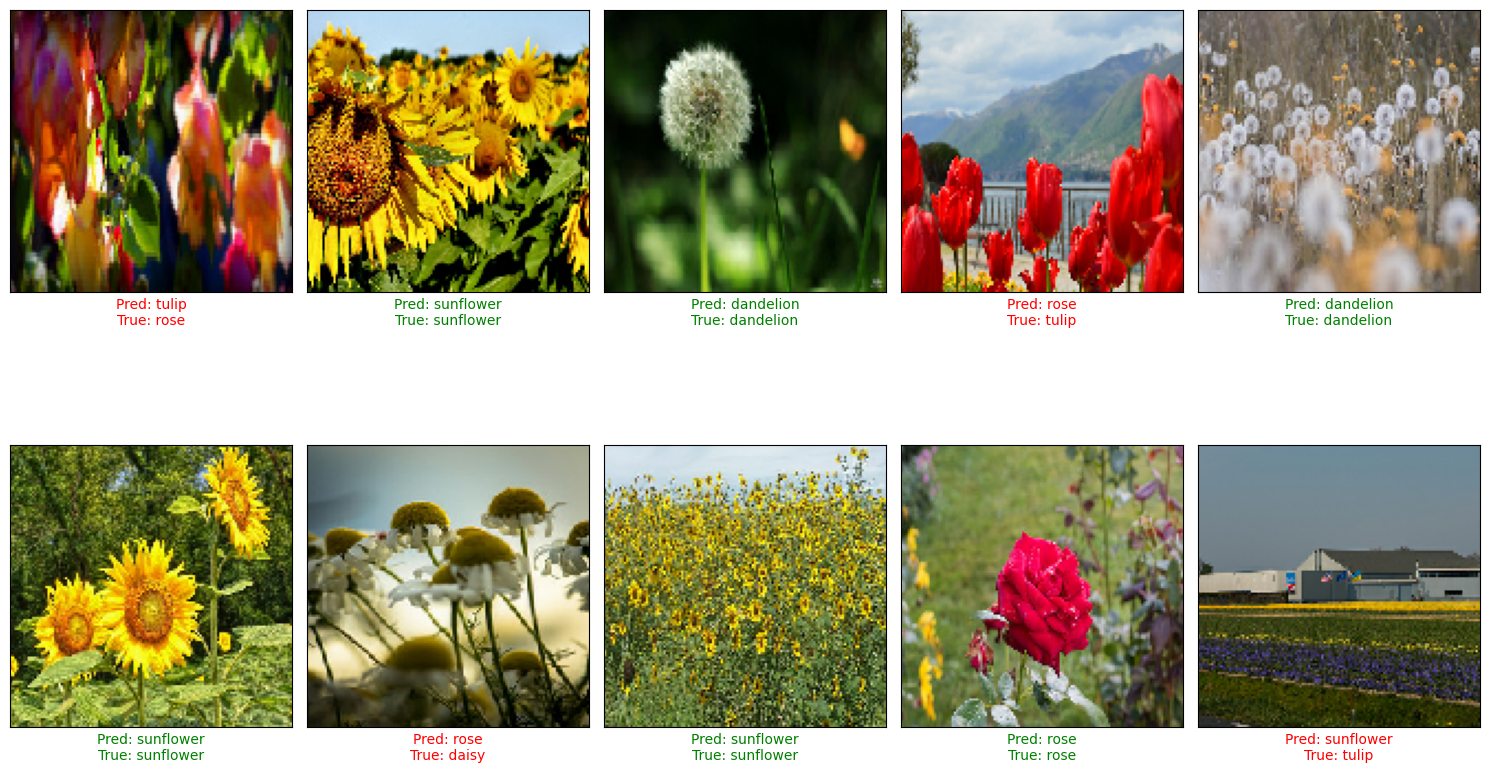

In [14]:
print("\nFetching a batch of test data for plotting...")
try:

    if tf.data.experimental.cardinality(test_ds).numpy() > 0:
        test_images_batch, test_labels_batch = next(iter(test_ds.take(1)))
        test_images_batch_np = test_images_batch.numpy()
        test_labels_batch_np = test_labels_batch.numpy()

        predictions = model.predict(test_images_batch_np)


        def plot_images(images, true_labels_int, pred_probs, class_names, num_images=10):
            plt.figure(figsize=(15, 10))
            for i in range(min(num_images, len(images))):
                plt.subplot(2, 5, i+1)

                plt.imshow(images[i])

                true_label = true_labels_int[i]
                pred_label = np.argmax(pred_probs[i])

                color = 'green' if true_label == pred_label else 'red'

                plt.xlabel(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                           color=color)
                plt.xticks([])
                plt.yticks([])
            plt.tight_layout()
            plt.show()

        print("Displaying predictions for a batch of test images:")
        plot_images(test_images_batch_np,
                    test_labels_batch_np,
                    predictions,
                    class_names,
                    num_images=10)
    else:
        print("Test dataset is empty. Cannot fetch a batch for plotting.")

except StopIteration:
    print("Could not fetch a batch from the test dataset (StopIteration). Test dataset might be empty or exhausted.")
except Exception as e:
    print(f"An error occurred during plotting: {e}")

#**Analyzes the test set to find incorrect predictions.Visualizes up to 10 incorrect predictions with true/predicted labels.**


Attempting to find incorrect predictions from the entire test set (this might take a moment)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step

Found 171 incorrect predictions.
Displaying 10 incorrect predictions:


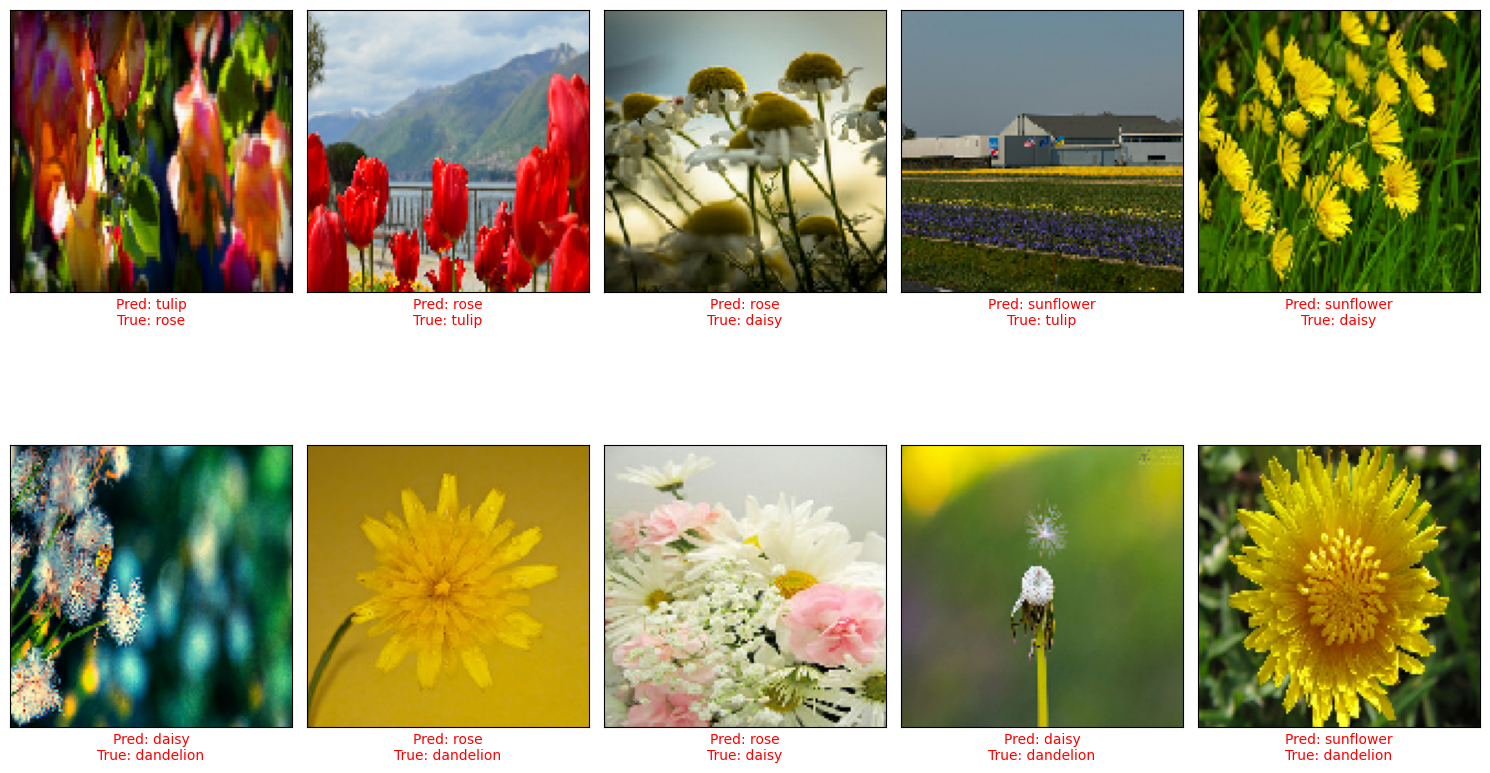

In [15]:
incorrect_indices = []
print("\nAttempting to find incorrect predictions from the entire test set (this might take a moment)...")

all_test_images = []
all_test_labels = []
all_predictions = []

try:
    if tf.data.experimental.cardinality(test_ds).numpy() > 0:
        for images, labels in test_ds:
            all_test_images.append(images.numpy())
            all_test_labels.append(labels.numpy())
            all_predictions.append(model.predict(images.numpy()))

        if all_test_images:
            all_test_images_np = np.concatenate(all_test_images)
            all_test_labels_np = np.concatenate(all_test_labels)
            all_predictions_np = np.concatenate(all_predictions)

            predicted_classes = np.argmax(all_predictions_np, axis=1)
            incorrect_indices = np.where(predicted_classes != all_test_labels_np)[0]

            if len(incorrect_indices) > 0:
                print(f"\nFound {len(incorrect_indices)} incorrect predictions.")
                num_incorrect_to_show = min(10, len(incorrect_indices))
                print(f"Displaying {num_incorrect_to_show} incorrect predictions:")
                plot_images(all_test_images_np[incorrect_indices[:num_incorrect_to_show]],
                            all_test_labels_np[incorrect_indices[:num_incorrect_to_show]],
                            all_predictions_np[incorrect_indices[:num_incorrect_to_show]],
                            class_names,
                            num_incorrect_to_show)
            else:
                print("\nNo incorrect predictions found in the test set.")
        else:
            print("No data collected from the test set to find incorrect predictions.")
    else:
        print("Test dataset is empty. Cannot find incorrect predictions.")

except Exception as e:
     print(f"An error occurred while finding incorrect predictions: {e}")